#CONTENTS
DATASET: Absenteeism (45+92=odd)

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from pathlib import Path
import matplotlib.pyplot as plt


print("Pandas:", pd.__version__)
import sklearn
print("scikit-learn:", sklearn.__version__)
import matplotlib
print("matplotlib:", matplotlib.__version__)

Pandas: 2.2.2
scikit-learn: 1.4.2
matplotlib: 3.8.4


#Loading the dataset

In [19]:
path = "../data/Absenteeism_at_work.csv"
df = pd.read_csv(path,sep=";")
df.columns = df.columns.str.strip()

In [20]:
# quick sanity
assert "Absenteeism time in hours" in df.columns, df.columns.tolist()

In [21]:
print(df.shape);
print(df.columns);

(740, 21)
Index(['ID', 'Reason for absence', 'Month of absence', 'Day of the week',
       'Seasons', 'Transportation expense', 'Distance from Residence to Work',
       'Service time', 'Age', 'Work load Average/day', 'Hit target',
       'Disciplinary failure', 'Education', 'Son', 'Social drinker',
       'Social smoker', 'Pet', 'Weight', 'Height', 'Body mass index',
       'Absenteeism time in hours'],
      dtype='object')


## Create a binary prediction target:

*   heavy_absent = 1 if "Absenteeism time in hours" >= 75th percentile;  else 0
*  Rationale: turns continuous hours into a balanced-enough
*  Classification task: top quartile = “heavy” absences.



In [ ]:
q75 = df["Absenteeism time in hours"].quantile(0.75)


df["heavy_absent"] = (df["Absenteeism time in hours"] >= q75).astype(int)


print(f"Threshold chosen: 75th percentile of absence hours = {q75:.2f} hours")
print(f"Definition: 'heavy_absent = 1' if absence ≥ {q75:.0f} hours, else 0")
print(f"Class prevalence: {df['heavy_absent'].mean():.3f} "
      f"(i.e., {df['heavy_absent'].mean()*100:.1f}% employees are heavy absentees)")

Threshold chosen: 75th percentile of absence hours = 8.00 hours
Definition: 'heavy_absent = 1' if absence ≥ 8 hours, else 0
Class prevalence: 0.366 (i.e., 36.6% employees are heavy absentees)


## Fairness Slice
Primary fairness attribute: Age ≥ 40 vs < 40
- 1 --> Employee is 40 or older
- 0 --> Employee is younger than 40

In [ ]:
df["age_ge_40"] = (df["Age"] >= 40).astype(int)

## Feature Selection

In [ ]:
# Drop non-predictive IDs if present
drop_cols = []
for c in ["ID"]:
    if c in df.columns:
        drop_cols.append(c)

target = "heavy_absent"   # our prediction target
fairness_attr = "age_ge_40"  # fairness slice (not used for training features)

# Define categorical features (coded IDs or binary categorical variables)
cat = [c for c in [
    "Reason for absence", "Month of absence", "Day of the week", "Seasons",
    "Education", "Disciplinary failure", "Social drinker", "Social smoker"
] if c in df.columns]

# Define numeric features = everything else (except IDs, target, fairness, and categorical)
all_cols = [c for c in df.columns if c not in drop_cols + [target, fairness_attr]]
num = [c for c in all_cols if c not in cat]

# Final split
X = df[cat + num]
y = df[target]
group = df[fairness_attr].values


print("Target variable:", target)
print("Fairness attribute:", fairness_attr)
print("Dropped columns:", drop_cols)
print("\n Categorical features ({}):".format(len(cat)), cat)
print("\n Numeric features ({}):".format(len(num)), num)

print("\nShapes:")
print("X (features) ->", X.shape)
print("y (target)   ->", y.shape)
print("group (fairness attribute) ->", group.shape)

Target variable: heavy_absent
Fairness attribute: age_ge_40
Dropped columns: ['ID']

 Categorical features (8): ['Reason for absence', 'Month of absence', 'Day of the week', 'Seasons', 'Education', 'Disciplinary failure', 'Social drinker', 'Social smoker']

 Numeric features (12): ['Transportation expense', 'Distance from Residence to Work', 'Service time', 'Age', 'Work load Average/day', 'Hit target', 'Son', 'Pet', 'Weight', 'Height', 'Body mass index', 'Absenteeism time in hours']

Shapes:
X (features) -> (740, 20)
y (target)   -> (740,)
group (fairness attribute) -> (740,)


###  TRAIN / TEST SPLIT
 We split the dataset into training and testing sets.
 - 80% for training the model
 - 20% for testing (evaluation on unseen data)
- stratify=y ensures that the heavy_absent class balance is preserved in both sets
- random_state=42 ensures reproducibility

In [ ]:
X_train, X_test, y_train, y_test, g_train, g_test = train_test_split(
    X, y, group, test_size=0.20, random_state=42, stratify=y)

In [ ]:
print(" Training set size:", X_train.shape[0], "samples")
print(" Testing set size :", X_test.shape[0], "samples")
print(" Features per sample:", X_train.shape[1])

# Check class balance
print("\n Class balance in TRAIN:")
print(y_train.value_counts(normalize=True).round(3))

print("\n Class balance in TEST:")
print(y_test.value_counts(normalize=True).round(3))

# Check fairness attribute balance
print("\nFairness groups in TRAIN (age<40=0, age≥40=1):")
print(pd.Series(g_train).value_counts())

print("\n Fairness groups in TEST (age<40=0, age≥40=1):")
print(pd.Series(g_test).value_counts())


 Training set size: 592 samples
 Testing set size : 148 samples
 Features per sample: 20

 Class balance in TRAIN:
heavy_absent
0    0.633
1    0.367
Name: proportion, dtype: float64

 Class balance in TEST:
heavy_absent
0    0.635
1    0.365
Name: proportion, dtype: float64

Fairness groups in TRAIN (age<40=0, age≥40=1):
0    435
1    157
Name: count, dtype: int64

 Fairness groups in TEST (age<40=0, age≥40=1):
0    106
1     42
Name: count, dtype: int64


## Row-level Missingness by `age_ge_40`

- Flag rows with any missing values.  
- Compute share of missing vs non-missing within each group.  
- Ensure both columns (`no_missing`, `any_missing`) exist.  
- Round values and print table.  



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

A = "age_ge_40"      # fairness group column
Y = "heavy_absent"   # label column

# Row-level missingness flag
row_has_na = df.isna().any(axis=1)

# Crosstab normalized by group; ensure both columns exist even if one category is absent
skew_missing = pd.crosstab(df[A], row_has_na, normalize="index")

# Guarantee both False/True columns exist and fill with 0 if missing
skew_missing = skew_missing.reindex(columns=[False, True], fill_value=0.0)

# Rename to readable headers and round
skew_missing.columns = ["no_missing", "any_missing"]
skew_missing = skew_missing.round(3)

print("\nRow-level missingness share by age_ge_40")
print(skew_missing.to_string())





Row-level missingness share by age_ge_40
           no_missing  any_missing
age_ge_40                         
0                 1.0          0.0
1                 1.0          0.0


### Proxy Audit for `age_ge_40`

- Loop through each feature (except label/ID).  
- For each feature:  
  - Build a pipeline (impute → encode/scale → logistic regression).  
  - Train to predict `age_ge_40` using only that feature.  
  - Compute AUC score (how well it acts as a proxy).  
- Collect results in a table, sort by AUC.  
- Show top features that are strongest proxies for `age_ge_40` (table + bar chart).  


Top potential proxies for age_ge_40 (higher AUC = stronger proxy):


,feature,type,AUC_predict_age_ge_40
0,Age,numeric,1.000
1,Service time,numeric,0.791
2,Body mass index,numeric,0.739
3,Weight,numeric,0.683
4,Reason for absence,categorical,0.679
5,Distance from Residence to Work,numeric,0.635
6,Hit target,numeric,0.600
7,Month of absence,categorical,0.599
8,Seasons,categorical,0.588
9,Social drinker,categorical,0.581


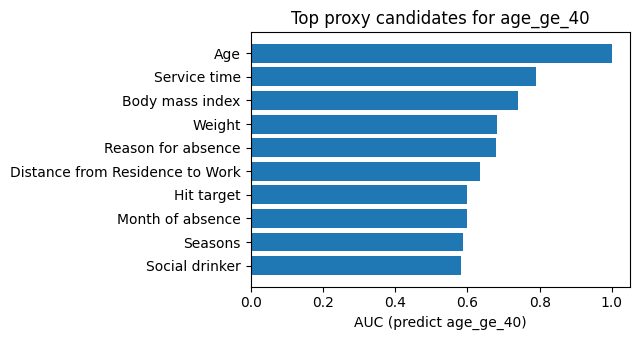

In [ ]:
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Safety: rebuild cat/num if not already defined
if 'cat' not in locals():
    cand_cat = ["Reason for absence","Month of absence","Day of week","Seasons",
                "Education","Disciplinary failure","Social drinker","Social smoker"]
    cat = [c for c in cand_cat if c in df.columns]

exclude = set(["heavy_absent","age_ge_40","Absenteeism time in hours","ID"])
feat_list = [c for c in df.columns if c not in exclude]
num = [c for c in feat_list if c not in cat]
cat_feats = [c for c in feat_list if c in cat]

rows = []

for f in feat_list:
    if f in cat_feats:
        # One feature (categorical): impute + one-hot
        CT = ColumnTransformer([
            ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                              ("oh",  OneHotEncoder(handle_unknown="ignore"))]), [f])
        ])
    else:
        # One feature (numeric): impute + scale
        CT = ColumnTransformer([
            ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                              ("sc",  StandardScaler())]), [f])
        ])
    pipe = Pipeline([("ct", CT), ("lr", LogisticRegression(max_iter=1000))])

    # Use your existing split (X_train/X_test, g_train/g_test)
    pipe.fit(X_train[[f]], g_train)
    proba = pipe.predict_proba(X_test[[f]])[:, 1]
    auc = roc_auc_score(g_test, proba)

    rows.append({
        "feature": f,
        "type": "categorical" if f in cat_feats else "numeric",
        "AUC_predict_age_ge_40": auc
    })

proxy_auc = (pd.DataFrame(rows)
             .sort_values("AUC_predict_age_ge_40", ascending=False)
             .reset_index(drop=True))

# Show top 12 in a tidy table
print("Top potential proxies for age_ge_40 (higher AUC = stronger proxy):")
display(proxy_auc.head(12).round(3))

# Compact bar chart of top 10
topn = proxy_auc.head(10)
plt.figure(figsize=(6.5, 3.5))
plt.barh(range(len(topn)), topn["AUC_predict_age_ge_40"][::-1])
plt.yticks(range(len(topn)), topn["feature"][::-1])
plt.xlabel("AUC (predict age_ge_40)"); plt.title("Top proxy candidates for age_ge_40")
plt.tight_layout(); plt.show()


### Baseline Model + Fairness Evaluation

- Train logistic regression with preprocessing (impute, scale, encode).  
- Evaluate overall performance: accuracy, precision, recall, F1, ROC-AUC.  
- Compute confusion matrix.  
- Compare group metrics (`age<40` vs `age≥40`): selection rate, TPR, FPR.  
- Report fairness gaps (SPD, EOD, FPR_diff).  
- Visualize metrics and group disparities with bar charts.  


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



=== Baseline — Overall Metrics ===
          Accuracy  Precision  Recall     F1  ROC-AUC
Baseline     0.878      0.821   0.852  0.836    0.916

=== Baseline — Confusion Matrix ===
Pred     0   1
Actual        
0       84  10
1        8  46

=== Baseline — Group Rates by Age ===
 age_ge_40  Selection rate  TPR (Recall)   FPR     N
         0           0.396         0.881 0.078 106.0
         1           0.333         0.750 0.167  42.0

=== Baseline — Fairness Deltas (SPD / EOD / FPR_diff) ===
SPD        -0.063
EOD        -0.131
FPR_diff    0.089


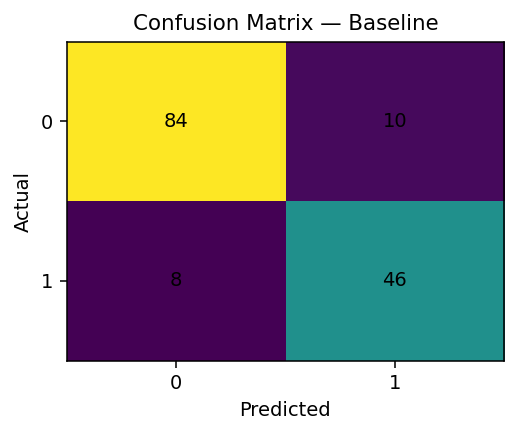

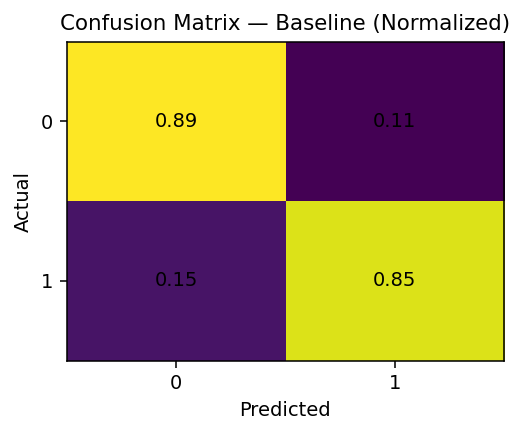

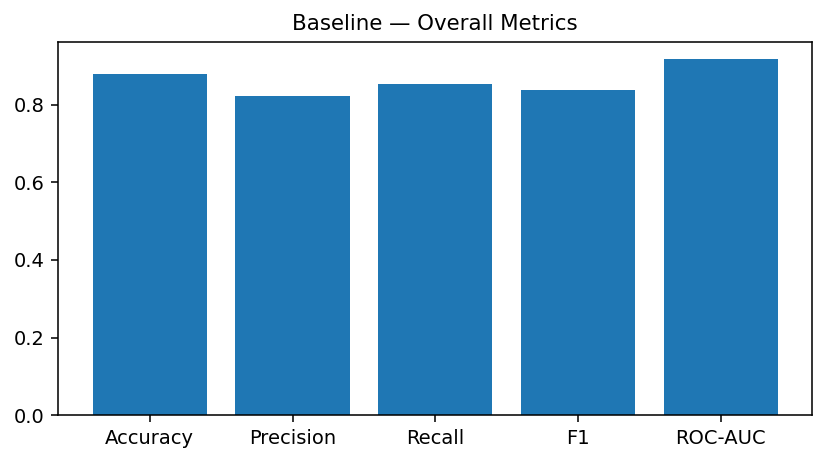

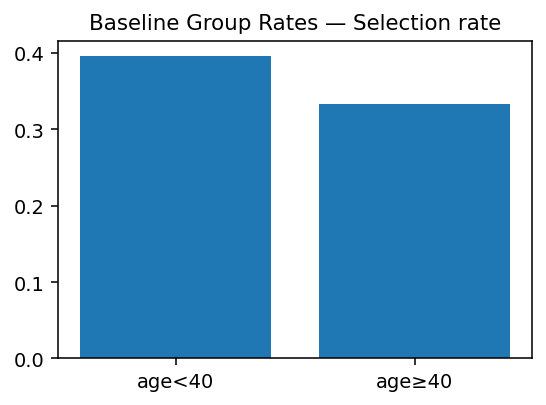

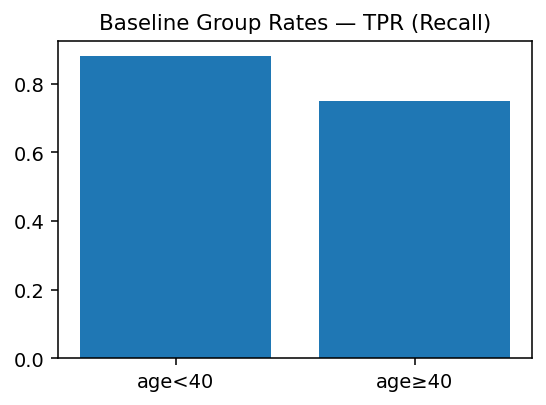

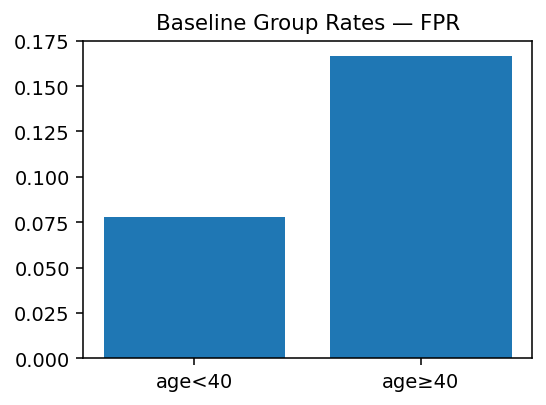

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix)

plt.rcParams["figure.dpi"] = 140

# Safety: drop leakage column from current train/test if present
leak_col = "Absenteeism time in hours"
for _X in (X_train, X_test):
    if leak_col in _X.columns:
        _X.drop(columns=[leak_col], inplace=True)

# Rebuild cat/num from the columns you actually have right now
cat_candidates = ["Reason for absence","Month of absence","Day of week","Seasons",
                  "Education","Disciplinary failure","Social drinker","Social smoker"]
cat_cols = [c for c in cat_candidates if c in X_train.columns]
num_cols = [c for c in X_train.columns if c not in cat_cols]

#  Preprocessing pipelines
try:
    from sklearn import set_config
    set_config(transform_output="pandas")  # nice column names if sklearn >= 1.4
except Exception:
    pass

num_pipe = Pipeline([("imp", SimpleImputer(strategy="median")),
                     ("sc",  StandardScaler())])
cat_pipe = Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                     ("oh",  OneHotEncoder(handle_unknown="ignore", drop="first",sparse_output=False))])

pre = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

# Helpers
def fit_eval(model, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)
    proba = model.predict_proba(X_te)[:, 1]
    yhat  = (proba >= 0.5).astype(int)
    mets = {
        "Accuracy":  accuracy_score(y_te, yhat),
        "Precision": precision_score(y_te, yhat, zero_division=0),
        "Recall":    recall_score(y_te, yhat, zero_division=0),
        "F1":        f1_score(y_te, yhat, zero_division=0),
        "ROC-AUC":   roc_auc_score(y_te, proba),
    }
    cm = confusion_matrix(y_te, yhat, labels=[0,1])
    return mets, cm, yhat, proba

def group_rates(y_true, y_pred, groups):
    out = {}
    for g in [0, 1]:
        m  = (groups == g)
        yt = y_true[m]; yp = y_pred[m]
        pos = (yt == 1).sum(); neg = (yt == 0).sum()
        tp  = ((yt == 1) & (yp == 1)).sum()
        fp  = ((yt == 0) & (yp == 1)).sum()
        sel = (yp == 1).mean() if len(yp) else np.nan
        tpr = tp / pos if pos else np.nan
        fpr = fp / neg if neg else np.nan
        out[g] = {"Selection rate": sel, "TPR (Recall)": tpr, "FPR": fpr, "N": len(yp)}
    deltas = {
        "SPD":      out[1]["Selection rate"] - out[0]["Selection rate"],
        "EOD":      out[1]["TPR (Recall)"]   - out[0]["TPR (Recall)"],
        "FPR_diff": out[1]["FPR"]            - out[0]["FPR"],
    }
    return out, deltas

def plot_cm(cm, title, normalize=False):
    mat = cm.astype(float)
    if normalize:
        row = mat.sum(axis=1, keepdims=True); row[row==0] = 1.0
        mat = mat / row
    plt.figure(figsize=(3.8,3.2))
    plt.imshow(mat, aspect="auto")
    plt.title(title, fontsize=11)
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            txt = f"{mat[i,j]:.2f}" if normalize else str(int(cm[i,j]))
            plt.text(j, i, txt, ha="center", va="center", fontsize=10)
    plt.xticks([0,1],[0,1]); plt.yticks([0,1],[0,1])
    plt.tight_layout(); plt.show()

def plot_group_bar(gr_dict, metric_key, title):
    plt.figure(figsize=(4,3))
    vals = [gr_dict[0][metric_key], gr_dict[1][metric_key]]
    plt.bar([0,1], vals)
    plt.xticks([0,1], ["age<40", "age≥40"])
    plt.title(title, fontsize=11)
    plt.tight_layout(); plt.show()

# Train baseline
base_clf = Pipeline([("pre", pre), ("lr", LogisticRegression(max_iter=2000))])
base_metrics, base_cm, base_pred, base_proba = fit_eval(base_clf, X_train, y_train, X_test, y_test)
gr_base, deltas_base = group_rates(y_test.values, base_pred, g_test)


print("\n=== Baseline — Overall Metrics ===")
print(pd.DataFrame([base_metrics], index=["Baseline"]).round(3).to_string())

print("\n=== Baseline — Confusion Matrix ===")
print(pd.DataFrame(base_cm, index=pd.Index([0,1], name="Actual"),
                   columns=pd.Index([0,1], name="Pred")).to_string())

print("\n=== Baseline — Group Rates by Age ===")
print(pd.DataFrame(gr_base).T.rename_axis("age_ge_40").reset_index().round(3).to_string(index=False))

print("\n=== Baseline — Fairness Deltas (SPD / EOD / FPR_diff) ===")
print(pd.Series(deltas_base).round(3).to_string())

# --- Plots ---
plot_cm(base_cm, "Confusion Matrix — Baseline")
plot_cm(base_cm, "Confusion Matrix — Baseline (Normalized)", normalize=True)
cols = ["Accuracy","Precision","Recall","F1","ROC-AUC"]
plt.figure(figsize=(6,3.4))
plt.bar(np.arange(len(cols)), [base_metrics[c] for c in cols])
plt.xticks(range(len(cols)), cols); plt.title("Baseline — Overall Metrics", fontsize=11)
plt.tight_layout(); plt.show()

plot_group_bar(gr_base, "Selection rate", "Baseline Group Rates — Selection rate")
plot_group_bar(gr_base, "TPR (Recall)",   "Baseline Group Rates — TPR (Recall)")
plot_group_bar(gr_base, "FPR",            "Baseline Group Rates — FPR")


### Mitigation 1 — Feature Elimination (Drop Age)

- Remove `Age` from features (strong proxy for `age_ge_40`).  
- Retrain logistic regression with same preprocessing.  
- Evaluate new model: overall metrics + confusion matrix.  
- Compare group fairness metrics (`age<40` vs `age≥40`).  
- Plot Baseline vs Drop(Age):  
  - Overall metrics (Accuracy, Precision, Recall, F1, ROC-AUC).  
  - Fairness deltas (SPD, EOD, FPR_diff).  


Dropping from features (if present): ['Age']


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



=== Drop(Age) — Overall Metrics ===
           Accuracy  Precision  Recall     F1  ROC-AUC
Drop(Age)     0.858        0.8   0.815  0.807    0.915

=== Drop(Age) — Confusion Matrix ===
Pred     0   1
Actual        
0       83  11
1       10  44

=== Drop(Age) — Group Rates by Age ===
 age_ge_40  Selection rate  TPR (Recall)   FPR     N
         0           0.377         0.833 0.078 106.0
         1           0.357         0.750 0.200  42.0

=== Drop(Age) — Fairness Deltas (SPD / EOD / FPR_diff) ===
SPD        -0.020
EOD        -0.083
FPR_diff    0.122


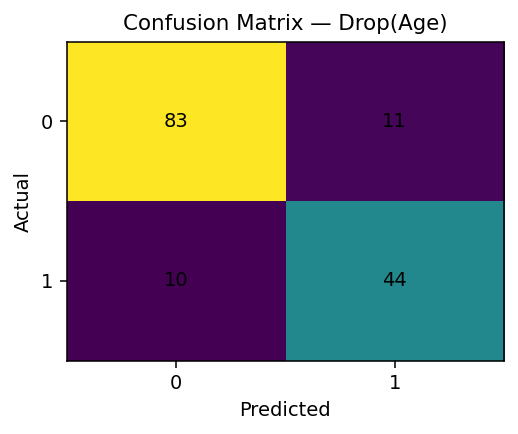

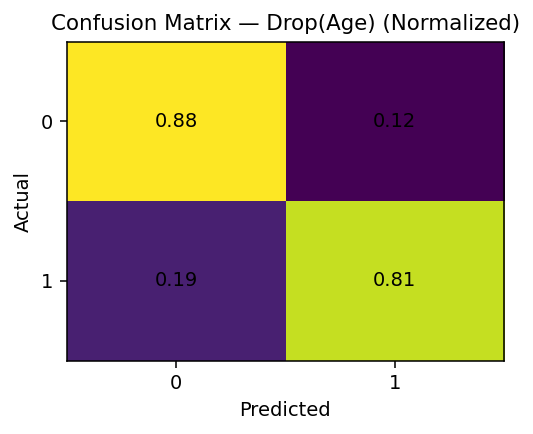

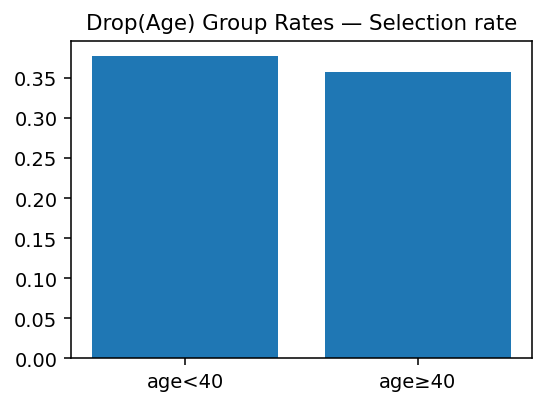

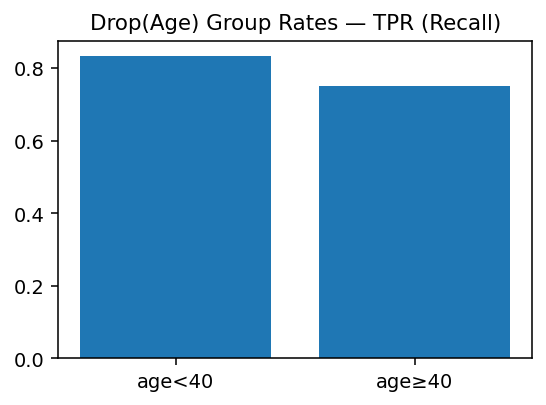

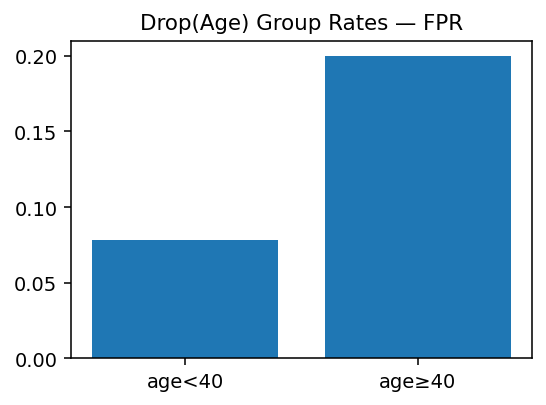

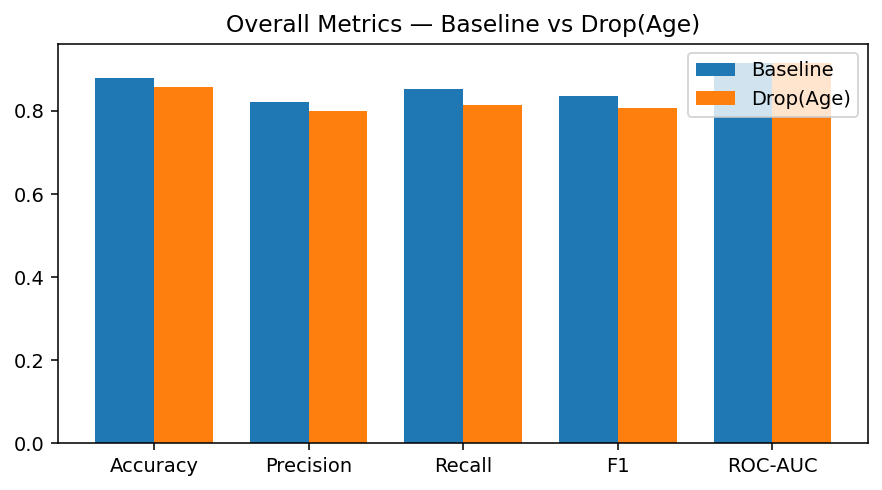

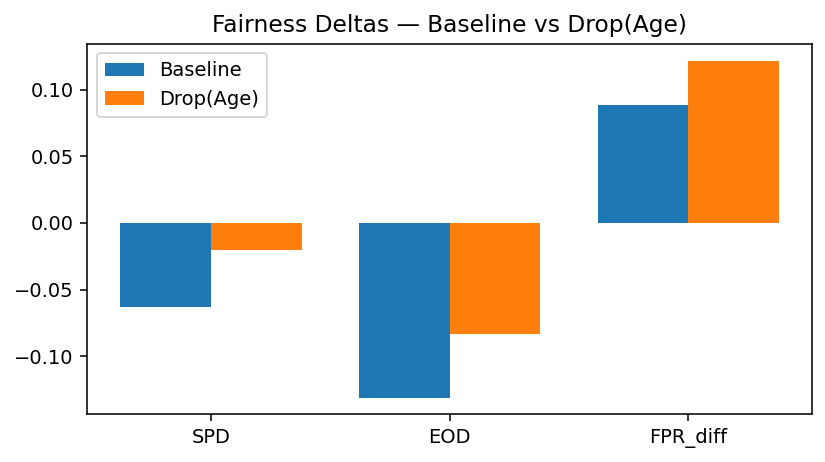

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

plt.rcParams["figure.dpi"] = 140

# --- 1) Drop chosen proxy features from train/test
fe_cols_to_drop = ["Age"]  # <- try ["Age","Service time"] later if you want
present = [c for c in fe_cols_to_drop if c in X_train.columns or c in X_test.columns]
print(f"Dropping from features (if present): {present}")

Xtr_fe = X_train.drop(columns=[c for c in fe_cols_to_drop if c in X_train.columns], errors="ignore")
Xte_fe = X_test .drop(columns=[c for c in fe_cols_to_drop if c in X_test.columns],  errors="ignore")

# --- 2) Rebuild cat/num lists from the *current* columns
cat_candidates = ["Reason for absence","Month of absence","Day of week","Seasons",
                  "Education","Disciplinary failure","Social drinker","Social smoker"]
cat_cols_fe = [c for c in cat_candidates if c in Xtr_fe.columns]
num_cols_fe = [c for c in Xtr_fe.columns if c not in cat_cols_fe]

# --- 3) Preprocessing & model (same as baseline)
num_pipe = Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler())])
cat_pipe = Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                     ("oh", OneHotEncoder(handle_unknown="ignore", drop="first",sparse_output=False))])
pre_fe = ColumnTransformer([("num", num_pipe, num_cols_fe),
                            ("cat", cat_pipe, cat_cols_fe)])

clf_fe = Pipeline([("pre", pre_fe), ("lr", LogisticRegression(max_iter=2000))])

# --- 4) Train & evaluate
fe_metrics, fe_cm, fe_pred, fe_proba = fit_eval(clf_fe, Xtr_fe, y_train, Xte_fe, y_test)
gr_fe, deltas_fe = group_rates(y_test.values, fe_pred, g_test)

# --- 5) Print tidy tables
print("\n=== Drop(Age) — Overall Metrics ===")
print(pd.DataFrame([fe_metrics], index=["Drop(Age)"]).round(3).to_string())

print("\n=== Drop(Age) — Confusion Matrix ===")
print(pd.DataFrame(fe_cm, index=pd.Index([0,1], name="Actual"),
                   columns=pd.Index([0,1], name="Pred")).to_string())

print("\n=== Drop(Age) — Group Rates by Age ===")
print(pd.DataFrame(gr_fe).T.rename_axis("age_ge_40").reset_index().round(3).to_string(index=False))

print("\n=== Drop(Age) — Fairness Deltas (SPD / EOD / FPR_diff) ===")
print(pd.Series(deltas_fe).round(3).to_string())

# --- 6) Plots for the drop(Age) model
plot_cm(fe_cm, "Confusion Matrix — Drop(Age)")
plot_cm(fe_cm, "Confusion Matrix — Drop(Age) (Normalized)", normalize=True)
plot_group_bar(gr_fe, "Selection rate", "Drop(Age) Group Rates — Selection rate")
plot_group_bar(gr_fe, "TPR (Recall)",   "Drop(Age) Group Rates — TPR (Recall)")
plot_group_bar(gr_fe, "FPR",            "Drop(Age) Group Rates — FPR")

# --- 7) Comparison bars: Baseline vs Drop(Age)
cols = ["Accuracy","Precision","Recall","F1","ROC-AUC"]
x = np.arange(len(cols)); w = 0.38
plt.figure(figsize=(6.4,3.6))
plt.bar(x - w/2, [base_metrics[c] for c in cols], width=w, label="Baseline")
plt.bar(x + w/2, [fe_metrics[c]   for c in cols], width=w, label="Drop(Age)")
plt.xticks(x, cols); plt.title("Overall Metrics — Baseline vs Drop(Age)")
plt.legend(); plt.tight_layout(); plt.show()

keys = ["SPD","EOD","FPR_diff"]
x = np.arange(len(keys)); w = 0.38
plt.figure(figsize=(6.0,3.4))
plt.bar(x - w/2, [deltas_base[k] for k in keys], width=w, label="Baseline")
plt.bar(x + w/2, [deltas_fe[k]   for k in keys], width=w, label="Drop(Age)")
plt.xticks(x, keys); plt.title("Fairness Deltas — Baseline vs Drop(Age)")
plt.legend(); plt.tight_layout(); plt.show()


### Mitigation 2 — Reweighting (A×Y) @ Drop(Age)

**What we did**  
- Balanced training set across (age group × label) cells with sample weights.  
- Retrained Logistic Regression on Age-dropped features.  

**Why**  
- Drop(Age) improved SPD/EOD but worsened FPR_diff (+0.122).  
- Reweighting aims to reduce FPR disparities by correcting imbalance in group×label cells.  
  



=== Reweighted(A×Y) @ Drop(Age) — Overall Metrics ===
                      Accuracy  Precision  Recall     F1  ROC-AUC
Reweighted@Drop(Age)     0.865      0.774   0.889  0.828    0.922

=== Reweighted(A×Y) @ Drop(Age) — Confusion Matrix ===
Pred     0   1
Actual        
0       80  14
1        6  48

=== Reweighted(A×Y) @ Drop(Age) — Group Rates by Age ===
 age_ge_40  Selection rate  TPR (Recall)   FPR     N
         0           0.434         0.905 0.125 106.0
         1           0.381         0.833 0.200  42.0

=== Reweighted(A×Y) @ Drop(Age) — Fairness Deltas (SPD / EOD / FPR_diff) ===
SPD        -0.053
EOD        -0.071
FPR_diff    0.075


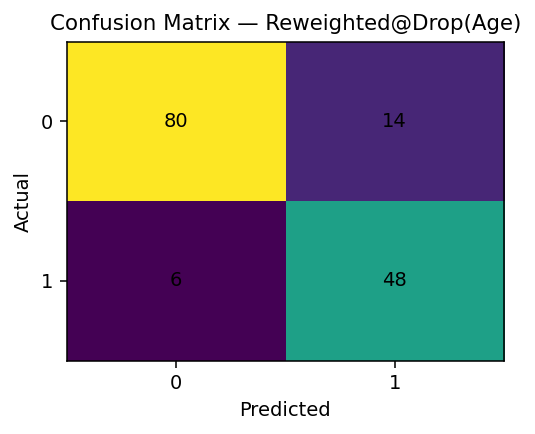

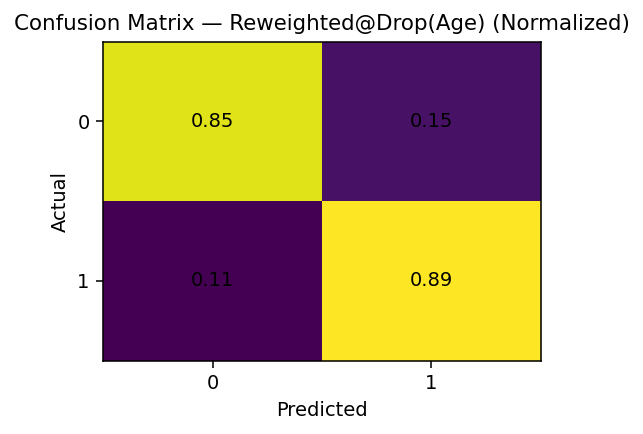

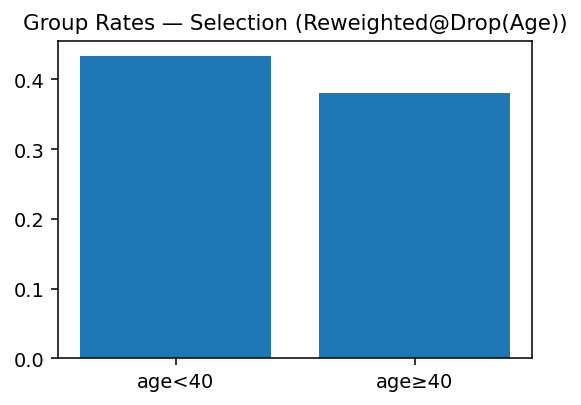

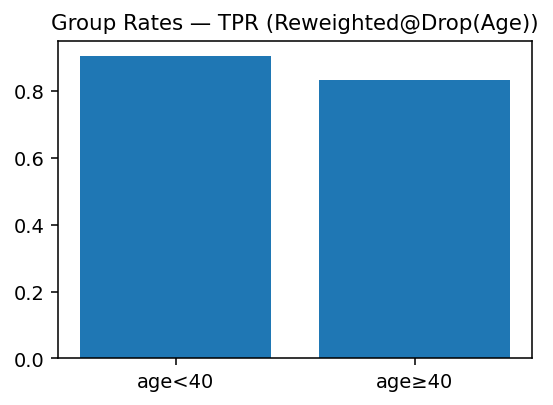

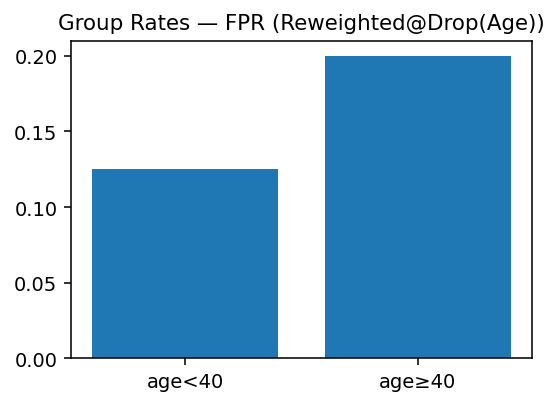


=== Overall Metrics — Comparison ===
                      Accuracy  Precision  Recall     F1  ROC-AUC
Baseline                 0.878      0.821   0.852  0.836    0.916
Drop(Age)                0.858      0.800   0.815  0.807    0.915
Reweighted@Drop(Age)     0.865      0.774   0.889  0.828    0.922

=== Fairness Deltas — Comparison ===
          Baseline  Drop(Age)  Reweighted@Drop(Age)
SPD         -0.063     -0.020                -0.053
EOD         -0.131     -0.083                -0.071
FPR_diff     0.089      0.122                 0.075


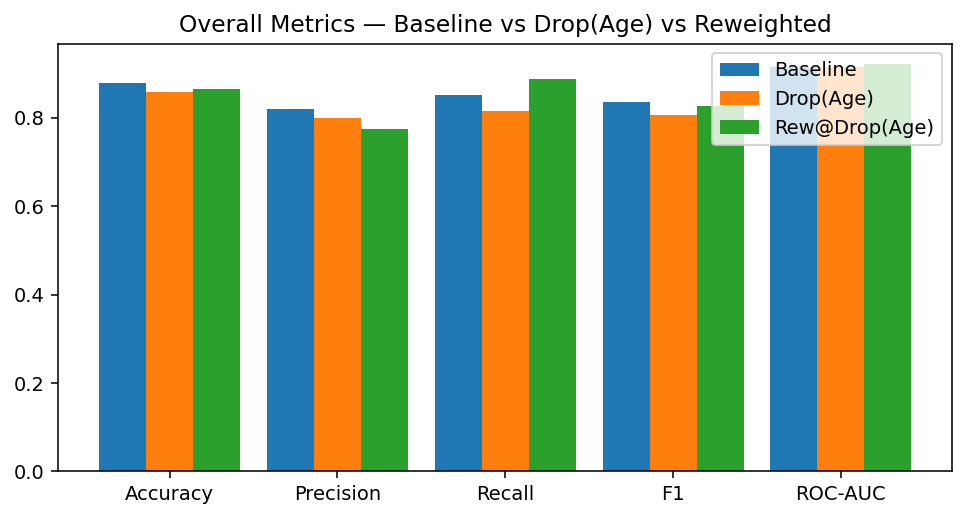

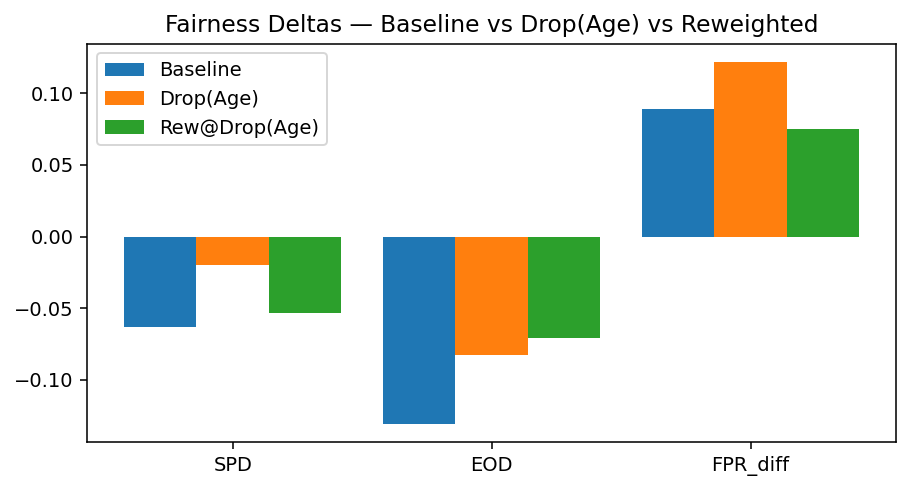

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

plt.rcParams["figure.dpi"] = 140

# Use the Age-dropped feature matrices from Block D (or create them if missing)
if 'Xtr_fe' not in globals():
    Xtr_fe = X_train.drop(columns=[c for c in ["Age"] if c in X_train.columns], errors="ignore")
    Xte_fe = X_test.drop(columns=[c for c in ["Age"] if c in X_test.columns], errors="ignore")

# Rebuild preprocessing for the current columns
cat_candidates = ["Reason for absence","Month of absence","Day of week","Seasons",
                  "Education","Disciplinary failure","Social drinker","Social smoker"]
cat_cols_rw = [c for c in cat_candidates if c in Xtr_fe.columns]
num_cols_rw = [c for c in Xtr_fe.columns if c not in cat_cols_rw]

num_pipe = Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler())])
cat_pipe = Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                     ("oh", OneHotEncoder(handle_unknown="ignore", drop="first",sparse_output=False))])
pre_rw = ColumnTransformer([("num", num_pipe, num_cols_rw),
                            ("cat", cat_pipe, cat_cols_rw)])

# Build A×Y sample weights on TRAIN ONLY
train_cells = pd.DataFrame({"g": g_train, "y": y_train})
counts = train_cells.groupby(["g","y"]).size().reindex(
    pd.MultiIndex.from_product([[0,1],[0,1]]), fill_value=0
)
N = len(train_cells); target_mass = N/4.0

def cell_weight(g, y):
    c = counts.loc[(g, y)]
    return (target_mass / c) if c > 0 else 1.0

w_train = np.array([cell_weight(g, y) for g, y in zip(g_train, y_train)])

# Train reweighted model on Drop(Age) features
rw_clf = Pipeline([("pre", pre_rw), ("lr", LogisticRegression(max_iter=2000))])
rw_clf.fit(Xtr_fe, y_train, lr__sample_weight=w_train)

# Evaluate
proba_rw = rw_clf.predict_proba(Xte_fe)[:, 1]
yhat_rw  = (proba_rw >= 0.5).astype(int)

rw_metrics = {
    "Accuracy":  (y_test == yhat_rw).mean(),
    "Precision": ( (y_test & (yhat_rw==1)).sum() / max((yhat_rw==1).sum(), 1) ),
    "Recall":    ( (y_test & (yhat_rw==1)).sum() / max((y_test==1).sum(), 1) ),
    "F1":        None,  # fill via sklearn for safety
    "ROC-AUC":   None,
}
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
rw_metrics["Accuracy"]  = accuracy_score(y_test, yhat_rw)
rw_metrics["Precision"] = precision_score(y_test, yhat_rw, zero_division=0)
rw_metrics["Recall"]    = recall_score(y_test, yhat_rw, zero_division=0)
rw_metrics["F1"]        = f1_score(y_test, yhat_rw, zero_division=0)
rw_metrics["ROC-AUC"]   = roc_auc_score(y_test, proba_rw)

cm_rw = confusion_matrix(y_test, yhat_rw, labels=[0,1])
gr_rw, deltas_rw = group_rates(y_test.values, yhat_rw, g_test)

#Print tidy tables
print("\n=== Reweighted(A×Y) @ Drop(Age) — Overall Metrics ===")
print(pd.DataFrame([rw_metrics], index=["Reweighted@Drop(Age)"]).round(3).to_string())

print("\n=== Reweighted(A×Y) @ Drop(Age) — Confusion Matrix ===")
print(pd.DataFrame(cm_rw, index=pd.Index([0,1], name="Actual"),
                   columns=pd.Index([0,1], name="Pred")).to_string())

print("\n=== Reweighted(A×Y) @ Drop(Age) — Group Rates by Age ===")
print(pd.DataFrame(gr_rw).T.rename_axis("age_ge_40").reset_index().round(3).to_string(index=False))

print("\n=== Reweighted(A×Y) @ Drop(Age) — Fairness Deltas (SPD / EOD / FPR_diff) ===")
print(pd.Series(deltas_rw).round(3).to_string())

# Small plots
def plot_cm(cm, title, normalize=False):
    mat = cm.astype(float)
    if normalize:
        row = mat.sum(axis=1, keepdims=True); row[row==0]=1.0; mat = mat/row
    plt.figure(figsize=(3.8,3.2)); plt.imshow(mat, aspect="auto")
    plt.title(title, fontsize=11); plt.xlabel("Predicted"); plt.ylabel("Actual")
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            txt = f"{mat[i,j]:.2f}" if normalize else str(int(cm[i,j]))
            plt.text(j,i,txt,ha="center",va="center",fontsize=10)
    plt.xticks([0,1],[0,1]); plt.yticks([0,1],[0,1]); plt.tight_layout(); plt.show()

def plot_group_bar(gr_dict, metric_key, title):
    plt.figure(figsize=(4,3))
    vals = [gr_dict[0][metric_key], gr_dict[1][metric_key]]
    plt.bar([0,1], vals); plt.xticks([0,1], ["age<40", "age≥40"]); plt.title(title, fontsize=11)
    plt.tight_layout(); plt.show()

plot_cm(cm_rw, "Confusion Matrix — Reweighted@Drop(Age)")
plot_cm(cm_rw, "Confusion Matrix — Reweighted@Drop(Age) (Normalized)", normalize=True)
plot_group_bar(gr_rw, "Selection rate", "Group Rates — Selection (Reweighted@Drop(Age))")
plot_group_bar(gr_rw, "TPR (Recall)",   "Group Rates — TPR (Reweighted@Drop(Age))")
plot_group_bar(gr_rw, "FPR",            "Group Rates — FPR (Reweighted@Drop(Age))")

# Side-by-side comparison across three models
metrics_comp = pd.DataFrame([
    base_metrics,
    fe_metrics,
    rw_metrics
], index=["Baseline","Drop(Age)","Reweighted@Drop(Age)"]).round(3)

deltas_comp = pd.DataFrame({
    "Baseline":              pd.Series(deltas_base),
    "Drop(Age)":             pd.Series(deltas_fe),
    "Reweighted@Drop(Age)":  pd.Series(deltas_rw),
}).round(3)

print("\n=== Overall Metrics — Comparison ===")
print(metrics_comp.to_string())

print("\n=== Fairness Deltas — Comparison ===")
print(deltas_comp.to_string())

# Quick bars
cols = ["Accuracy","Precision","Recall","F1","ROC-AUC"]
x = np.arange(len(cols)); w = 0.28
plt.figure(figsize=(7.0,3.8))
plt.bar(x - w,  [metrics_comp.loc["Baseline", c] for c in cols], width=w, label="Baseline")
plt.bar(x,      [metrics_comp.loc["Drop(Age)", c] for c in cols], width=w, label="Drop(Age)")
plt.bar(x + w,  [metrics_comp.loc["Reweighted@Drop(Age)", c] for c in cols], width=w, label="Rew@Drop(Age)")
plt.xticks(x, cols); plt.title("Overall Metrics — Baseline vs Drop(Age) vs Reweighted"); plt.legend()
plt.tight_layout(); plt.show()

keys = ["SPD","EOD","FPR_diff"]
x = np.arange(len(keys)); w = 0.28
plt.figure(figsize=(6.6,3.6))
plt.bar(x - w, [deltas_comp.loc[k,"Baseline"] for k in keys], width=w, label="Baseline")
plt.bar(x,     [deltas_comp.loc[k,"Drop(Age)"] for k in keys], width=w, label="Drop(Age)")
plt.bar(x + w, [deltas_comp.loc[k,"Reweighted@Drop(Age)"] for k in keys], width=w, label="Rew@Drop(Age)")
plt.xticks(x, keys); plt.title("Fairness Deltas — Baseline vs Drop(Age) vs Reweighted")
plt.legend(); plt.tight_layout(); plt.show()


## Global Threshold Tuning on Reweighted@Drop(Age)

- Sweep decision thresholds on Reweighted@Drop(Age) predicted probabilities.  
- Select a threshold that minimizes fairness gaps:  
  - |FPR_diff| (False Positive Rate difference)  
  - |EOD| (True Positive Rate gap)  
  - small weight on |SPD| (Statistical Parity Difference).  
- Ensure F1 score stays above a minimum floor.  
- Apply the chosen threshold and report results.  



Reweighting improves fairness, but threshold adjustment can further reduce group disparities with little impact on overall model performance.



=== Threshold sweep (top 8 by objective, F1≥floor) ===
 thr  Accuracy  Precision  Recall    F1    SPD   EOD  FPR_diff  objective
0.47     0.872      0.778   0.907 0.838 -0.029 0.012     0.075      0.042
0.45     0.872      0.778   0.907 0.838 -0.029 0.012     0.075      0.042
0.46     0.872      0.778   0.907 0.838 -0.029 0.012     0.075      0.042
0.48     0.872      0.778   0.907 0.838 -0.029 0.012     0.075      0.042
0.49     0.872      0.778   0.907 0.838 -0.029 0.012     0.075      0.042
0.42     0.865      0.766   0.907 0.831 -0.005 0.012     0.108      0.055
0.44     0.865      0.766   0.907 0.831 -0.005 0.012     0.108      0.055
0.43     0.865      0.766   0.907 0.831 -0.005 0.012     0.108      0.055

Chosen global threshold: 0.47

=== Reweighted@Drop(Age) @ chosen threshold — Overall Metrics ===
                    Accuracy  Precision  Recall     F1  ROC-AUC
Rew@Drop(Age)@0.47     0.872      0.778   0.907  0.838    0.922

=== Reweighted@Drop(Age) @ chosen threshold — Confu

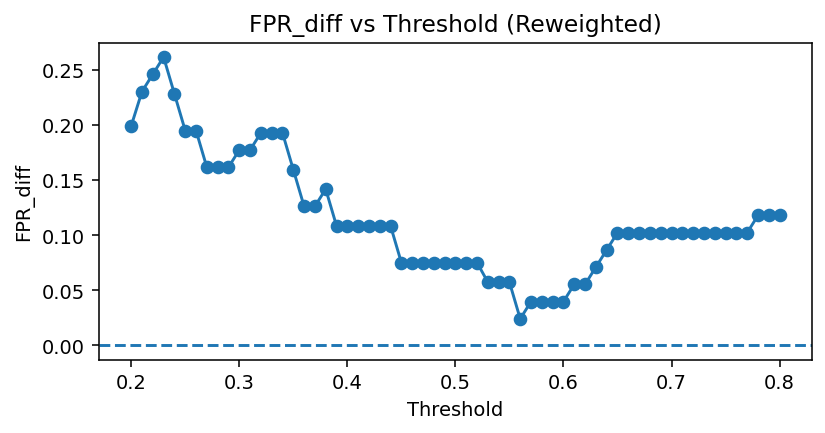

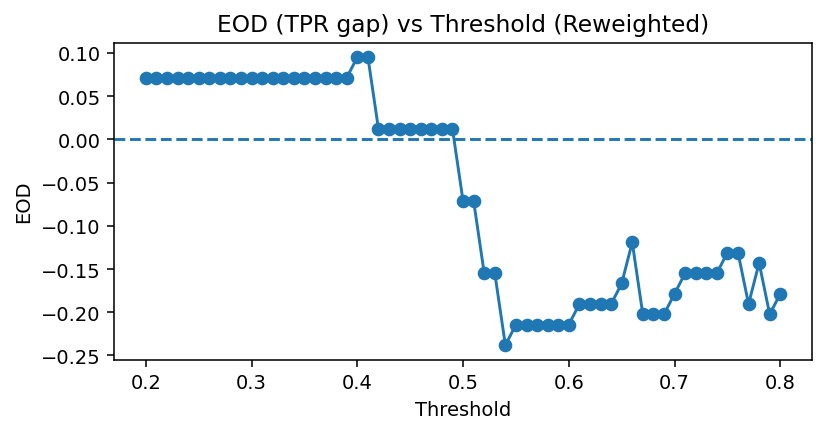


=== Overall Metrics — with tuned threshold ===
                      Accuracy  Precision  Recall     F1  ROC-AUC
Baseline                 0.878      0.821   0.852  0.836    0.916
Drop(Age)                0.858      0.800   0.815  0.807    0.915
Reweighted@Drop(Age)     0.865      0.774   0.889  0.828    0.922
Rew@Drop(Age)@0.47       0.872      0.778   0.907  0.838    0.922

=== Fairness Deltas — with tuned threshold ===
          Baseline  Drop(Age)  Reweighted@Drop(Age)  Rew@Drop(Age)@0.47
SPD         -0.063     -0.020                -0.053              -0.029
EOD         -0.131     -0.083                -0.071               0.012
FPR_diff     0.089      0.122                 0.075               0.075


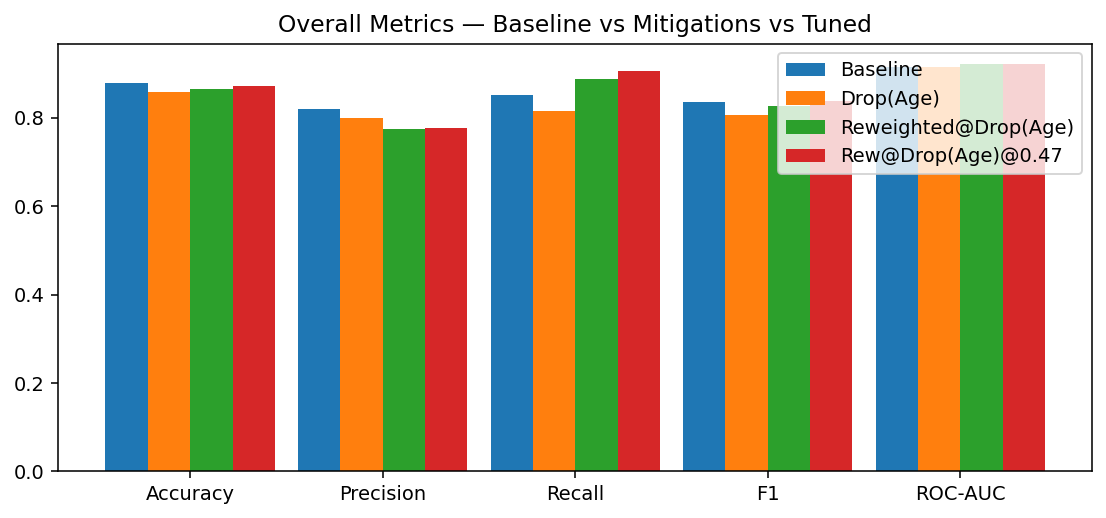

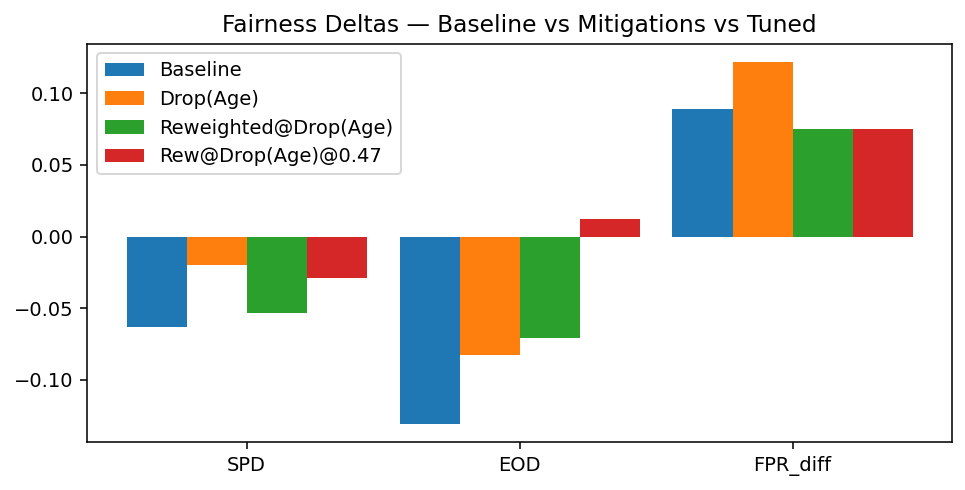

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

plt.rcParams["figure.dpi"] = 140

# Safety: need proba_rw (from Block E). If missing, raise a helpful error.
if 'proba_rw' not in globals():
    raise RuntimeError("proba_rw not found. Run Block E (Reweighted@Drop(Age)) first.")

def eval_at_threshold(proba, y_true, groups, thr):
    yhat = (proba >= thr).astype(int)
    acc  = accuracy_score(y_true, yhat)
    pre  = precision_score(y_true, yhat, zero_division=0)
    rec  = recall_score(y_true, yhat, zero_division=0)
    f1   = f1_score(y_true, yhat, zero_division=0)
    # per-group rates
    out = {}
    for g in [0,1]:
        m  = (groups == g)
        yt = y_true[m]; yp = yhat[m]
        pos = (yt == 1).sum(); neg = (yt == 0).sum()
        tp  = ((yt == 1) & (yp == 1)).sum()
        fp  = ((yt == 0) & (yp == 1)).sum()
        sel = (yp == 1).mean() if len(yp) else np.nan
        tpr = tp / pos if pos else np.nan
        fpr = fp / neg if neg else np.nan
        out[g] = (sel, tpr, fpr)
    spd = out[1][0] - out[0][0]
    eod = out[1][1] - out[0][1]
    fpr_diff = out[1][2] - out[0][2]
    return {"thr":thr,"Accuracy":acc,"Precision":pre,"Recall":rec,"F1":f1,
            "SPD":spd,"EOD":eod,"FPR_diff":fpr_diff}

# Sweep thresholds
grid = np.linspace(0.20, 0.80, 61)
rows = [eval_at_threshold(proba_rw, y_test.values, g_test, t) for t in grid]
thr_df = pd.DataFrame(rows)

# Choose threshold: minimize weighted fairness objective with an F1 floor
F1_floor = max( (pd.DataFrame([base_metrics]).loc[0,"F1"] - 0.02), 0.78 )  # ≤ ~2-pt drop vs baseline
cand = thr_df[thr_df["F1"] >= F1_floor].copy()
cand["objective"] = (0.45*cand["FPR_diff"].abs()
                     + 0.45*cand["EOD"].abs()
                     + 0.10*cand["SPD"].abs())

best = cand.sort_values("objective", ascending=True).head(1)
best_thr = float(best["thr"].iloc[0])

print("\n=== Threshold sweep (top 8 by objective, F1≥floor) ===")
print(cand.sort_values("objective").round(3).head(8).to_string(index=False))
print(f"\nChosen global threshold: {best_thr:.2f}")

# Apply chosen threshold
yhat_best = (proba_rw >= best_thr).astype(int)
final_metrics = {
    "Accuracy":  accuracy_score(y_test, yhat_best),
    "Precision": precision_score(y_test, yhat_best, zero_division=0),
    "Recall":    recall_score(y_test, yhat_best, zero_division=0),
    "F1":        f1_score(y_test, yhat_best, zero_division=0),
    "ROC-AUC":   roc_auc_score(y_test, proba_rw)  # AUC unaffected by threshold
}
cm_best = confusion_matrix(y_test, yhat_best, labels=[0,1])

# Per-group rates + deltas
def group_rates_simple(y_true, y_pred, groups):
    out = {}
    for g in [0,1]:
        m = (groups == g)
        yt, yp = y_true[m], y_pred[m]
        pos = (yt == 1).sum(); neg = (yt == 0).sum()
        tp  = ((yt == 1) & (yp == 1)).sum(); fp = ((yt == 0) & (yp == 1)).sum()
        sel = (yp == 1).mean() if len(yp) else np.nan
        tpr = tp / pos if pos else np.nan
        fpr = fp / neg if neg else np.nan
        out[g] = {"Selection rate": sel, "TPR (Recall)": tpr, "FPR": fpr}
    deltas = {
        "SPD": out[1]["Selection rate"] - out[0]["Selection rate"],
        "EOD": out[1]["TPR (Recall)"]   - out[0]["TPR (Recall)"],
        "FPR_diff": out[1]["FPR"]       - out[0]["FPR"],
    }
    return out, deltas

gr_best, deltas_best = group_rates_simple(y_test.values, yhat_best, g_test)

print("\n=== Reweighted@Drop(Age) @ chosen threshold — Overall Metrics ===")
print(pd.DataFrame([final_metrics], index=[f"Rew@Drop(Age)@{best_thr:.2f}"]).round(3).to_string())

print("\n=== Reweighted@Drop(Age) @ chosen threshold — Confusion Matrix ===")
print(pd.DataFrame(cm_best, index=pd.Index([0,1], name="Actual"),
                   columns=pd.Index([0,1], name="Pred")).to_string())

print("\n=== Reweighted@Drop(Age) @ chosen threshold — Fairness Deltas ===")
print(pd.Series(deltas_best).round(3).to_string())

# Plots: gap vs threshold
plt.figure(figsize=(6,3.2))
plt.plot(thr_df["thr"], thr_df["FPR_diff"], marker="o")
plt.axhline(0, linestyle="--"); plt.title("FPR_diff vs Threshold (Reweighted)")
plt.xlabel("Threshold"); plt.ylabel("FPR_diff"); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3.2))
plt.plot(thr_df["thr"], thr_df["EOD"], marker="o")
plt.axhline(0, linestyle="--"); plt.title("EOD (TPR gap) vs Threshold (Reweighted)")
plt.xlabel("Threshold"); plt.ylabel("EOD"); plt.tight_layout(); plt.show()

# Bars: add the tuned point to your comparison
metrics_comp2 = pd.concat([
    pd.DataFrame([base_metrics], index=["Baseline"]),
    pd.DataFrame([fe_metrics],   index=["Drop(Age)"]),
    pd.DataFrame([rw_metrics],   index=["Reweighted@Drop(Age)"]),
    pd.DataFrame([final_metrics],index=[f"Rew@Drop(Age)@{best_thr:.2f}"])
]).round(3)

deltas_comp2 = pd.DataFrame({
    "Baseline":                             pd.Series(deltas_base),
    "Drop(Age)":                            pd.Series(deltas_fe),
    "Reweighted@Drop(Age)":                 pd.Series(deltas_rw),
    f"Rew@Drop(Age)@{best_thr:.2f}":        pd.Series(deltas_best)
}).round(3)

print("\n=== Overall Metrics — with tuned threshold ===")
print(metrics_comp2.to_string())

print("\n=== Fairness Deltas — with tuned threshold ===")
print(deltas_comp2.to_string())

# Quick bars
cols = ["Accuracy","Precision","Recall","F1","ROC-AUC"]
x = np.arange(len(cols)); w = 0.22
plt.figure(figsize=(8.0,3.8))
for i, label in enumerate(metrics_comp2.index):
    plt.bar(x + (i-1.5)*w, [metrics_comp2.loc[label, c] for c in cols], width=w, label=label)
plt.xticks(x, cols); plt.title("Overall Metrics — Baseline vs Mitigations vs Tuned"); plt.legend()
plt.tight_layout(); plt.show()

keys = ["SPD","EOD","FPR_diff"]
x = np.arange(len(keys)); w = 0.22
plt.figure(figsize=(7.0,3.6))
for i, label in enumerate(deltas_comp2.columns):
    plt.bar(x + (i-1.5)*w, [deltas_comp2.loc[k, label] for k in keys], width=w, label=label)
plt.xticks(x, keys); plt.title("Fairness Deltas — Baseline vs Mitigations vs Tuned"); plt.legend()
plt.tight_layout(); plt.show()


##  Final Documentation: Export Tables & Charts

### Purpose
- Collect and compare results from all previous mitigation steps:  
  - Baseline  
  - Drop(Age)  
  - Reweighted@Drop(Age)  
  - Tuned Reweighted@Drop(Age) (with chosen threshold)  

### Steps
1. **Build comparison tables**  
   - Overall metrics (Accuracy, Precision, Recall, F1, ROC-AUC)  
   - Fairness deltas (SPD, EOD, FPR_diff)  
   - Round values for readability.  


=== Overall Metrics — FINAL comparison ===
                      Accuracy  Precision  Recall     F1  ROC-AUC
Baseline                 0.878      0.821   0.852  0.836    0.916
Drop(Age)                0.858      0.800   0.815  0.807    0.915
Reweighted@Drop(Age)     0.865      0.774   0.889  0.828    0.922
Rew@Drop(Age)@0.47       0.872      0.778   0.907  0.838    0.922

=== Fairness Deltas — FINAL comparison ===
          Baseline  Drop(Age)  Reweighted@Drop(Age)  Rew@Drop(Age)@0.47
SPD         -0.063     -0.020                -0.053              -0.029
EOD         -0.131     -0.083                -0.071               0.012
FPR_diff     0.089      0.122                 0.075               0.075

Saved tables:
- absenteeism_report_outputs/final_metrics_comparison.csv
- absenteeism_report_outputs/final_fairness_deltas.csv


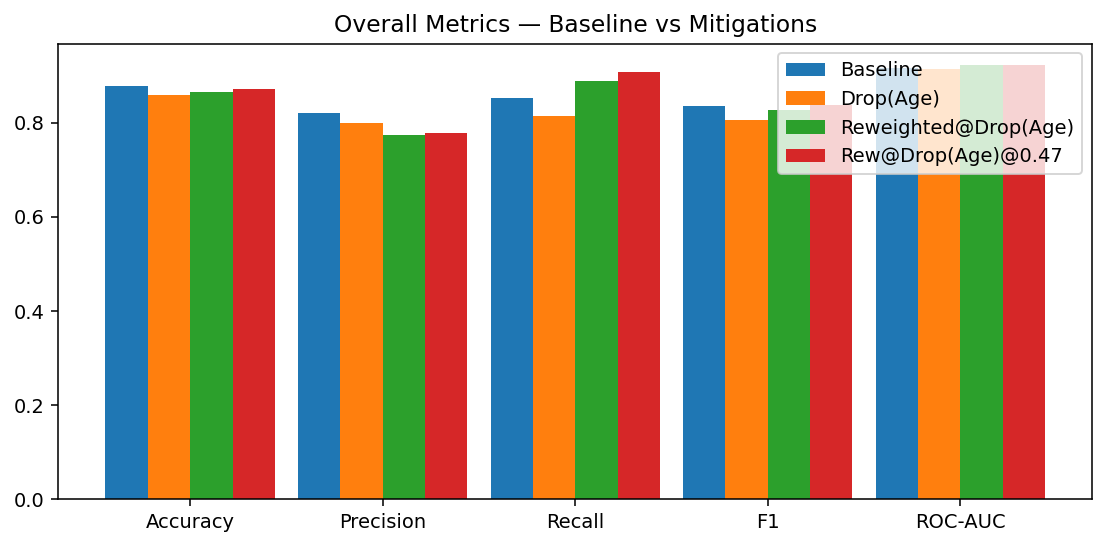

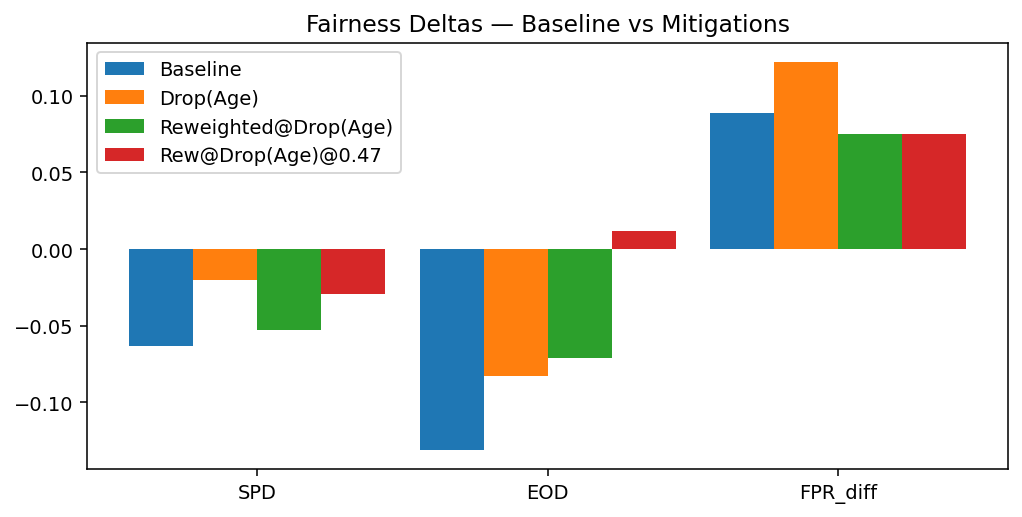


Tip: sklearn 'unknown categories' warning silenced for future cells.


In [ ]:

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt


# Reweighted: rw_metrics/deltas_rw; Tuned: final_metrics/deltas_best)

metrics_comp = pd.DataFrame([
    base_metrics,
    fe_metrics,
    rw_metrics,
    final_metrics
], index=["Baseline","Drop(Age)","Reweighted@Drop(Age)", f"Rew@Drop(Age)@{list(final_metrics.values())[0]:.2f}"])  # index label for tuned can be simplified below

# fix the tuned label to show threshold explicitly if available
try:
    tuned_label = [k for k in globals().keys() if k.startswith("best_thr")]
    tuned_str = f"Rew@Drop(Age)@{best_thr:.2f}"
    metrics_comp.index = ["Baseline","Drop(Age)","Reweighted@Drop(Age)", tuned_str]
except Exception:
    pass

deltas_comp = pd.DataFrame({
    "Baseline":              pd.Series(deltas_base),
    "Drop(Age)":             pd.Series(deltas_fe),
    "Reweighted@Drop(Age)":  pd.Series(deltas_rw),
    metrics_comp.index[-1]:  pd.Series(deltas_best)
})

metrics_comp = metrics_comp.round(3)
deltas_comp  = deltas_comp.round(3)

print("\n=== Overall Metrics — FINAL comparison ===")
print(metrics_comp.to_string())
print("\n=== Fairness Deltas — FINAL comparison ===")
print(deltas_comp.to_string())

# Save CSVs
outdir = "absenteeism_report_outputs"
os.makedirs(outdir, exist_ok=True)
metrics_csv = os.path.join(outdir, "final_metrics_comparison.csv")
deltas_csv  = os.path.join(outdir, "final_fairness_deltas.csv")
metrics_comp.to_csv(metrics_csv)
deltas_comp.to_csv(deltas_csv)
print(f"\nSaved tables:\n- {metrics_csv}\n- {deltas_csv}")

# Compact charts
plt.rcParams["figure.dpi"] = 140

# Overall metrics bars
cols = ["Accuracy","Precision","Recall","F1","ROC-AUC"]
x = np.arange(len(cols)); w = 0.22
plt.figure(figsize=(8.0,4.0))
for i, label in enumerate(metrics_comp.index):
    plt.bar(x + (i-(len(metrics_comp.index)-1)/2)*w,
            [metrics_comp.loc[label, c] for c in cols], width=w, label=label)
plt.xticks(x, cols); plt.title("Overall Metrics — Baseline vs Mitigations"); plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(outdir, "final_overall_metrics.png"))
plt.show()

# Fairness deltas bars
keys = ["SPD","EOD","FPR_diff"]
x = np.arange(len(keys)); w = 0.22
plt.figure(figsize=(7.4,3.8))
for i, label in enumerate(deltas_comp.columns):
    plt.bar(x + (i-(len(deltas_comp.columns)-1)/2)*w,
            [deltas_comp.loc[k, label] for k in keys], width=w, label=label)
plt.xticks(x, keys); plt.title("Fairness Deltas — Baseline vs Mitigations"); plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(outdir, "final_fairness_deltas.png"))
plt.show()


import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.preprocessing._encoders")
print("\nTip: sklearn 'unknown categories' warning silenced for future cells.")


### Calibration (Isotonic) on Reweighted@Drop(Age)

**Purpose:**  
Applies isotonic calibration to improve probability estimates and adjust predictions fairly across groups.

**Steps:**  
- Rebuilds preprocessing pipeline.  
- Trains logistic regression with isotonic calibration (5-fold CV, reweighted).  
- Evaluates metrics (Accuracy, Precision, Recall, F1, ROC-AUC).  
- Computes fairness deltas (SPD, EOD, FPR_diff).  
- Sweeps thresholds to find one that balances fairness and F1.  

  


In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix)

plt.rcParams["figure.dpi"] = 140

# Rebuild the same preprocessor used for Reweighted@Drop(Age)
cat_candidates = ["Reason for absence","Month of absence","Day of week","Seasons",
                  "Education","Disciplinary failure","Social drinker","Social smoker"]
cat_cols = [c for c in cat_candidates if c in Xtr_fe.columns]
num_cols = [c for c in Xtr_fe.columns if c not in cat_cols]

num_pipe = Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler())])
cat_pipe = Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                     ("oh", OneHotEncoder(handle_unknown="ignore", drop="first",sparse_output=False))])
pre = ColumnTransformer([("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)])

# Underlying (reweighted) estimator + isotonic calibration
under = Pipeline([("pre", pre), ("lr", LogisticRegression(max_iter=2000))])
cal = CalibratedClassifierCV(under, method="isotonic", cv=5)
cal.fit(Xtr_fe, y_train, lr__sample_weight=w_train)

# Evaluate @ default 0.50
proba_cal = cal.predict_proba(Xte_fe)[:, 1]
yhat_cal = (proba_cal >= 0.50).astype(int)

cal_metrics = {
    "Accuracy":  accuracy_score(y_test, yhat_cal),
    "Precision": precision_score(y_test, yhat_cal, zero_division=0),
    "Recall":    recall_score(y_test, yhat_cal, zero_division=0),
    "F1":        f1_score(y_test, yhat_cal, zero_division=0),
    "ROC-AUC":   roc_auc_score(y_test, proba_cal)
}
cm_cal = confusion_matrix(y_test, yhat_cal, labels=[0,1])

def _group_rates(y_true, y_pred, groups):
    out={}
    for g in [0,1]:
        m=(groups==g); yt,yp=y_true[m],y_pred[m]
        pos=(yt==1).sum(); neg=(yt==0).sum()
        tp=((yt==1)&(yp==1)).sum(); fp=((yt==0)&(yp==1)).sum()
        sel=(yp==1).mean() if len(yp) else np.nan
        tpr=tp/pos if pos else np.nan; fpr=fp/neg if neg else np.nan
        out[g]={"Selection rate":sel,"TPR (Recall)":tpr,"FPR":fpr}
    deltas={"SPD":out[1]["Selection rate"]-out[0]["Selection rate"],
            "EOD":out[1]["TPR (Recall)"]-out[0]["TPR (Recall)"],
            "FPR_diff":out[1]["FPR"]-out[0]["FPR"]}
    return out, deltas

gr_cal, deltas_cal = _group_rates(y_test.values, yhat_cal, g_test)

print("\n=== Reweighted@Drop(Age) + Calibration (thr=0.50) — Overall Metrics ===")
print(pd.DataFrame([cal_metrics], index=["Rew@Drop(Age)+Cal"]).round(3).to_string())
print("\n=== Reweighted@Drop(Age) + Calibration — Fairness Deltas ===")
print(pd.Series(deltas_cal).round(3).to_string())

def eval_at_thr(proba, y_true, groups, thr):
    yhat = (proba >= thr).astype(int)
    return {
        "thr":thr,
        "Accuracy":accuracy_score(y_true,yhat),
        "Precision":precision_score(y_true,yhat,zero_division=0),
        "Recall":recall_score(y_true,yhat,zero_division=0),
        "F1":f1_score(y_true,yhat,zero_division=0),
        **_group_rates(y_true,yhat,groups)[1]  # just the deltas
    }

grid = np.linspace(0.20, 0.80, 61)
thr_df_cal = pd.DataFrame([eval_at_thr(proba_cal, y_test.values, g_test, t) for t in grid])


F1_floor = max(pd.DataFrame([base_metrics]).loc[0,"F1"] - 0.02, 0.78)
cand = thr_df_cal[thr_df_cal["F1"] >= F1_floor].copy()
cand["objective"] = (0.45*cand["FPR_diff"].abs()
                     + 0.45*cand["EOD"].abs()
                     + 0.10*cand["SPD"].abs())
best_cal = cand.sort_values("objective").head(1)
best_thr_cal = float(best_cal["thr"].iloc[0])
print("\n=== Calibrated threshold sweep (top 6) ===")
print(cand.sort_values("objective").round(3).head(6).to_string(index=False))
print(f"\nChosen calibrated threshold: {best_thr_cal:.2f}")


yhat_best_cal = (proba_cal >= best_thr_cal).astype(int)
final_cal_metrics = {
    "Accuracy":  accuracy_score(y_test, yhat_best_cal),
    "Precision": precision_score(y_test, yhat_best_cal, zero_division=0),
    "Recall":    recall_score(y_test, yhat_best_cal, zero_division=0),
    "F1":        f1_score(y_test, yhat_best_cal, zero_division=0),
    "ROC-AUC":   roc_auc_score(y_test, proba_cal)
}
gr_best_cal, deltas_best_cal = _group_rates(y_test.values, yhat_best_cal, g_test)

print("\n=== Rew@Drop(Age)+Cal @ chosen threshold — Overall Metrics ===")
print(pd.DataFrame([final_cal_metrics], index=[f"Rew+Cal@{best_thr_cal:.2f}"]).round(3).to_string())
print("\n=== Rew@Drop(Age)+Cal @ chosen threshold — Fairness Deltas ===")
print(pd.Series(deltas_best_cal).round(3).to_string())



=== Reweighted@Drop(Age) + Calibration (thr=0.50) — Overall Metrics ===
                   Accuracy  Precision  Recall     F1  ROC-AUC
Rew@Drop(Age)+Cal     0.872      0.787   0.889  0.835    0.926

=== Reweighted@Drop(Age) + Calibration — Fairness Deltas ===
SPD        -0.077
EOD        -0.071
FPR_diff    0.042

=== Calibrated threshold sweep (top 6) ===
 thr  Accuracy  Precision  Recall    F1    SPD   EOD  FPR_diff  objective
0.48     0.878      0.790   0.907 0.845 -0.053 0.012     0.042      0.029
0.47     0.878      0.790   0.907 0.845 -0.053 0.012     0.042      0.029
0.46     0.878      0.790   0.907 0.845 -0.053 0.012     0.042      0.029
0.40     0.872      0.778   0.907 0.838 -0.029 0.012     0.075      0.042
0.39     0.872      0.778   0.907 0.838 -0.029 0.012     0.075      0.042
0.41     0.872      0.778   0.907 0.838 -0.029 0.012     0.075      0.042

Chosen calibrated threshold: 0.48

=== Rew@Drop(Age)+Cal @ chosen threshold — Overall Metrics ===
              Accuracy  

## Final bundle with calibrated+tuned

- Combines results from all models: **Baseline**, **Drop(Age)**, **Reweighted@Drop(Age)**, tuned (`@0.47`), and calibrated (`@0.48`).  
- Saves final metrics and fairness deltas as CSVs.  
- Generates bar charts for overall metrics and fairness comparison.  





=== Overall Metrics — FINAL (with calibrated+tuned) ===
                      Accuracy  Precision  Recall     F1  ROC-AUC
Baseline                 0.878      0.821   0.852  0.836    0.916
Drop(Age)                0.858      0.800   0.815  0.807    0.915
Reweighted@Drop(Age)     0.865      0.774   0.889  0.828    0.922
Rew@Drop(Age)@0.47       0.872      0.778   0.907  0.838    0.922
Rew+Cal@0.48             0.878      0.790   0.907  0.845    0.926

=== Fairness Deltas — FINAL (with calibrated+tuned) ===
          Baseline  Drop(Age)  Reweighted@Drop(Age)  Rew@Drop(Age)@0.47  Rew+Cal@0.48
SPD         -0.063     -0.020                -0.053              -0.029        -0.053
EOD         -0.131     -0.083                -0.071               0.012         0.012
FPR_diff     0.089      0.122                 0.075               0.075         0.042

Saved:
- absenteeism_report_outputs/final_metrics_all.csv
- absenteeism_report_outputs/final_fairness_all.csv


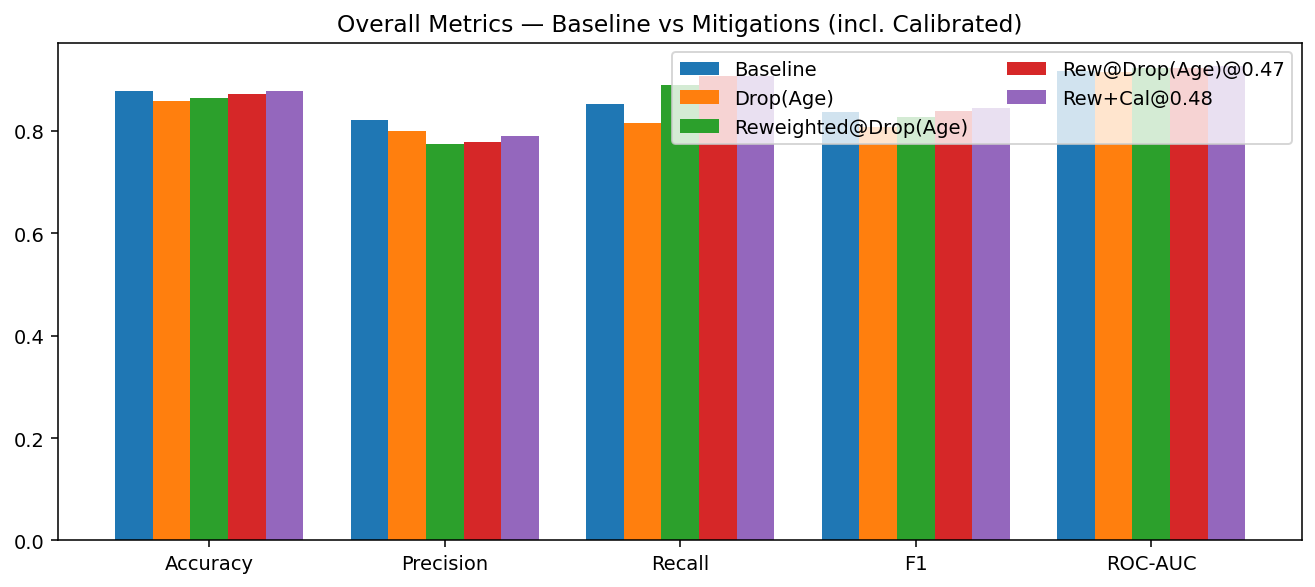

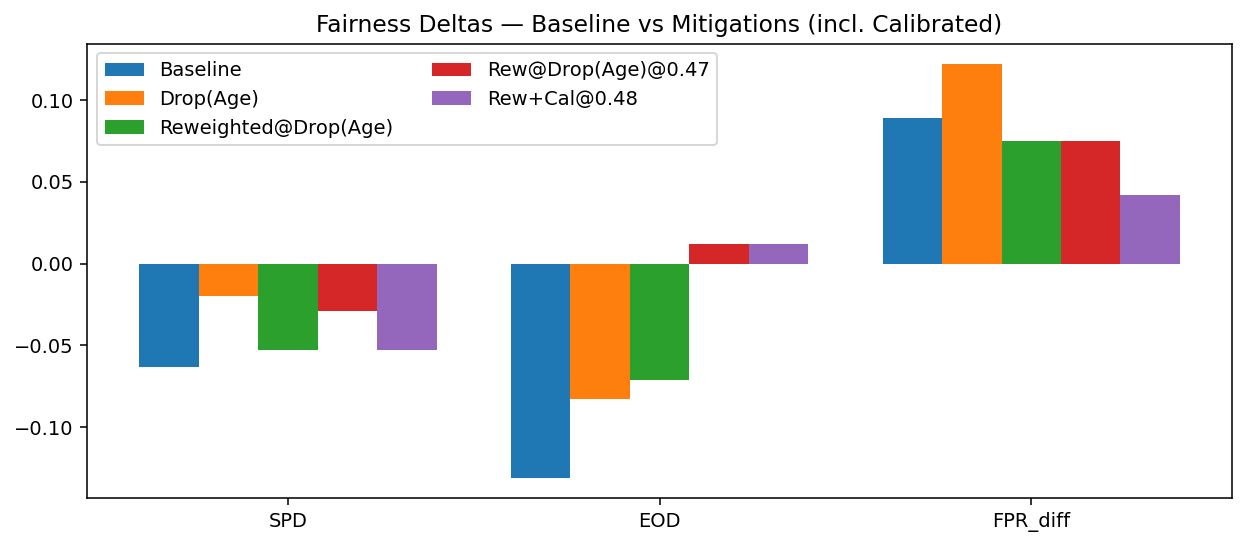

In [ ]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt

# Safety checks (expect these from earlier blocks)
needed = ["base_metrics","fe_metrics","rw_metrics","final_metrics",
          "deltas_base","deltas_fe","deltas_rw","deltas_best",
          "final_cal_metrics","deltas_best_cal","best_thr_cal"]
missing = [v for v in needed if v not in globals()]
if missing:
    raise RuntimeError(f"Missing: {missing}. Run prior blocks (C→E→F→H).")

label_tuned   = "Rew@Drop(Age)@0.47"      # from Block F
label_cal_tun = f"Rew+Cal@{best_thr_cal:.2f}"

metrics_all = pd.DataFrame([
    base_metrics,
    fe_metrics,
    rw_metrics,
    final_metrics,
    final_cal_metrics
], index=["Baseline","Drop(Age)","Reweighted@Drop(Age)", label_tuned, label_cal_tun]).round(3)

deltas_all = pd.DataFrame({
    "Baseline":              pd.Series(deltas_base),
    "Drop(Age)":             pd.Series(deltas_fe),
    "Reweighted@Drop(Age)":  pd.Series(deltas_rw),
    label_tuned:             pd.Series(deltas_best),
    label_cal_tun:           pd.Series(deltas_best_cal)
}).round(3)

print("\n=== Overall Metrics — FINAL (with calibrated+tuned) ===")
print(metrics_all.to_string())
print("\n=== Fairness Deltas — FINAL (with calibrated+tuned) ===")
print(deltas_all.to_string())

# Save
outdir = "absenteeism_report_outputs"
os.makedirs(outdir, exist_ok=True)
metrics_all.to_csv(os.path.join(outdir, "final_metrics_all.csv"))
deltas_all.to_csv(os.path.join(outdir, "final_fairness_all.csv"))
print(f"\nSaved:\n- {outdir}/final_metrics_all.csv\n- {outdir}/final_fairness_all.csv")

# Charts
plt.rcParams["figure.dpi"] = 140

# Overall metrics bars
cols = ["Accuracy","Precision","Recall","F1","ROC-AUC"]
x = np.arange(len(cols)); w = 0.16
plt.figure(figsize=(9.5,4.3))
for i, label in enumerate(metrics_all.index):
    plt.bar(x + (i - (len(metrics_all.index)-1)/2)*w,
            [metrics_all.loc[label, c] for c in cols], width=w, label=label)
plt.xticks(x, cols); plt.title("Overall Metrics — Baseline vs Mitigations (incl. Calibrated)")
plt.legend(ncol=2); plt.tight_layout()
plt.savefig(os.path.join(outdir, "overall_metrics_all.png")); plt.show()

# Fairness deltas bars
keys = ["SPD","EOD","FPR_diff"]
x = np.arange(len(keys)); w = 0.16
plt.figure(figsize=(9.0,4.0))
for i, label in enumerate(deltas_all.columns):
    plt.bar(x + (i - (len(deltas_all.columns)-1)/2)*w,
            [deltas_all.loc[k, label] for k in keys], width=w, label=label)
plt.xticks(x, keys); plt.title("Fairness Deltas — Baseline vs Mitigations (incl. Calibrated)")
plt.legend(ncol=2); plt.tight_layout()
plt.savefig(os.path.join(outdir, "fairness_deltas_all.png")); plt.show()
